# Airport Weather Delay Analysis & Ranking (Corrected for Storm Exposure)

This notebook analyzes and ranks the top 10 US airports by weather-related delays, correcting for regional storm exposure using both FAA flight data and external NOAA storm datasets.


# 1. Import Required Libraries
Import pandas, numpy, seaborn, matplotlib, plotnine, scipy, and other necessary libraries for data analysis and visualization.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
import scipy as sp
import statsmodels.formula.api as smf
import statistics

# 2. Load and Prepare Flight Data
Read the FAA flight data CSV, create relevant columns, and subset data for top 10 airports.

In [ ]:
# Load FAA flight data
Full_Data = pd.read_csv('faa_airports_all_thin.csv')

# Create delay/cancellation columns
Full_Data["Delayed"] = (Full_Data["DepDelayMinutes"] != 0).astype(int)
cancelled = Full_Data[(Full_Data["Cancelled"] == 1)]
cancelled_Weather = Full_Data[(Full_Data["Cancelled"] == 1) & (Full_Data["CancellationCode"] == "B")]
cancelled_Delay = Full_Data[(Full_Data["Cancelled"] == 1) & (Full_Data["DepDelayMinutes"]).notnull() & (Full_Data["DepDelayMinutes"]) != 0]
cancelled_Weather_Delay = Full_Data[(Full_Data["Cancelled"] == 1) & (Full_Data["CancellationCode"] == "B") & (Full_Data["DepDelayMinutes"]).notnull() & (Full_Data["DepDelayMinutes"]) != 0]
diverted = Full_Data[(Full_Data["Diverted"] == 1)]
diverted_Delay = Full_Data[(Full_Data["Diverted"] == 1) & (Full_Data["DepDelayMinutes"]).notnull() & (Full_Data["DepDelayMinutes"]) != 0]
delay = Full_Data[Full_Data['ArrDelayMinutes'].notnull() & (Full_Data["ArrDelayMinutes"]) != 0]
weather_Delay = delay[(delay['WeatherDelay'] != 0) & (delay['WeatherDelay'].notnull())]

# Top 10 airports
airport_codes = ['DFW', 'DEN', 'ORD', 'MCO', 'ATL', 'CLT', 'LAS', 'PHX', 'LAX', 'MIA']
outbound_flights = Full_Data[Full_Data['Origin'].isin(airport_codes)]
inbound_flights = Full_Data[Full_Data['Dest'].isin(airport_codes)]
inter_flights = Full_Data[(Full_Data['Origin'].isin(airport_codes)) & (Full_Data['Dest'].isin(airport_codes))]

# Replace NA with 0 for filled dataset
filled = Full_Data.fillna(0)
filled_delay = filled[filled['ArrDelayMinutes'] != 0]

# Subsets for top 10 airports
Top_10_From = Full_Data[Full_Data['Origin'].isin(airport_codes)]
Top_10_To = Full_Data[Full_Data['Dest'].isin(airport_codes)]

# 3. Univariate Analysis of Delay Variables
Generate descriptive statistics and histograms for key delay variables (arrival, departure, weather delays) using plotnine.

In [3]:
# Descriptive statistics
Full_Data.describe()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,TaxiOut,...,Flights,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,Div1AirportID,Delayed
count,3.949563e+06,3.949563e+06,3.949563e+06,3.949563e+06,3.949563e+06,3.875451e+06,3.875440e+06,3.875440e+06,3.875440e+06,3.873841e+06,...,3949563.0,3.949563e+06,843017.000000,843017.000000,843017.000000,843017.000000,843017.000000,24995.000000,10282.000000,3.949563e+06
mean,2.022246e+03,6.520411e+00,1.573565e+01,3.991084e+00,1.333107e+03,1.337188e+03,1.351080e+01,1.631582e+01,2.183675e-01,1.739349e+01,...,1.0,8.339249e+02,26.884139,3.893789,11.556492,0.130785,26.508407,1329.259292,12701.976561,4.099269e-01
std,4.304127e-01,3.423330e+00,8.781065e+00,2.000182e+00,4.967339e+02,5.116725e+02,5.670394e+01,5.578863e+01,4.131382e-01,9.092511e+00,...,0.0,5.820941e+02,80.225670,30.787398,28.126938,3.780105,60.846146,515.908741,1605.353038,4.918200e-01
min,2.022000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-9.000000e+01,0.000000e+00,0.000000e+00,1.000000e+00,...,1.0,6.700000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10135.000000,0.000000e+00
25%,2.022000e+03,4.000000e+00,8.000000e+00,2.000000e+00,9.100000e+02,9.120000e+02,-5.000000e+00,0.000000e+00,0.000000e+00,1.200000e+01,...,1.0,4.030000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,853.000000,11292.000000,0.000000e+00
50%,2.022000e+03,7.000000e+00,1.600000e+01,4.000000e+00,1.323000e+03,1.326000e+03,-1.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,...,1.0,7.080000e+02,6.000000,0.000000,0.000000,0.000000,0.000000,1343.000000,12478.000000,0.000000e+00
75%,2.022000e+03,9.000000e+00,2.300000e+01,6.000000e+00,1.740000e+03,1.750000e+03,1.100000e+01,1.100000e+01,0.000000e+00,2.000000e+01,...,1.0,1.069000e+03,25.000000,0.000000,15.000000,0.000000,30.000000,1739.000000,14107.000000,1.000000e+00
max,2.023000e+03,1.200000e+01,3.100000e+01,7.000000e+00,2.359000e+03,2.400000e+03,5.995000e+03,5.995000e+03,1.000000e+00,2.220000e+02,...,1.0,4.757000e+03,5986.000000,1582.000000,1436.000000,1245.000000,2530.000000,2400.000000,16257.000000,1.000000e+00


c:\ProgramData\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 2372'. Pick better value with 'binwidth'.
c:\ProgramData\anaconda3\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 103612 rows containing non-finite values.
c:\ProgramData\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_histogram : Removed 10 rows containing missing values.


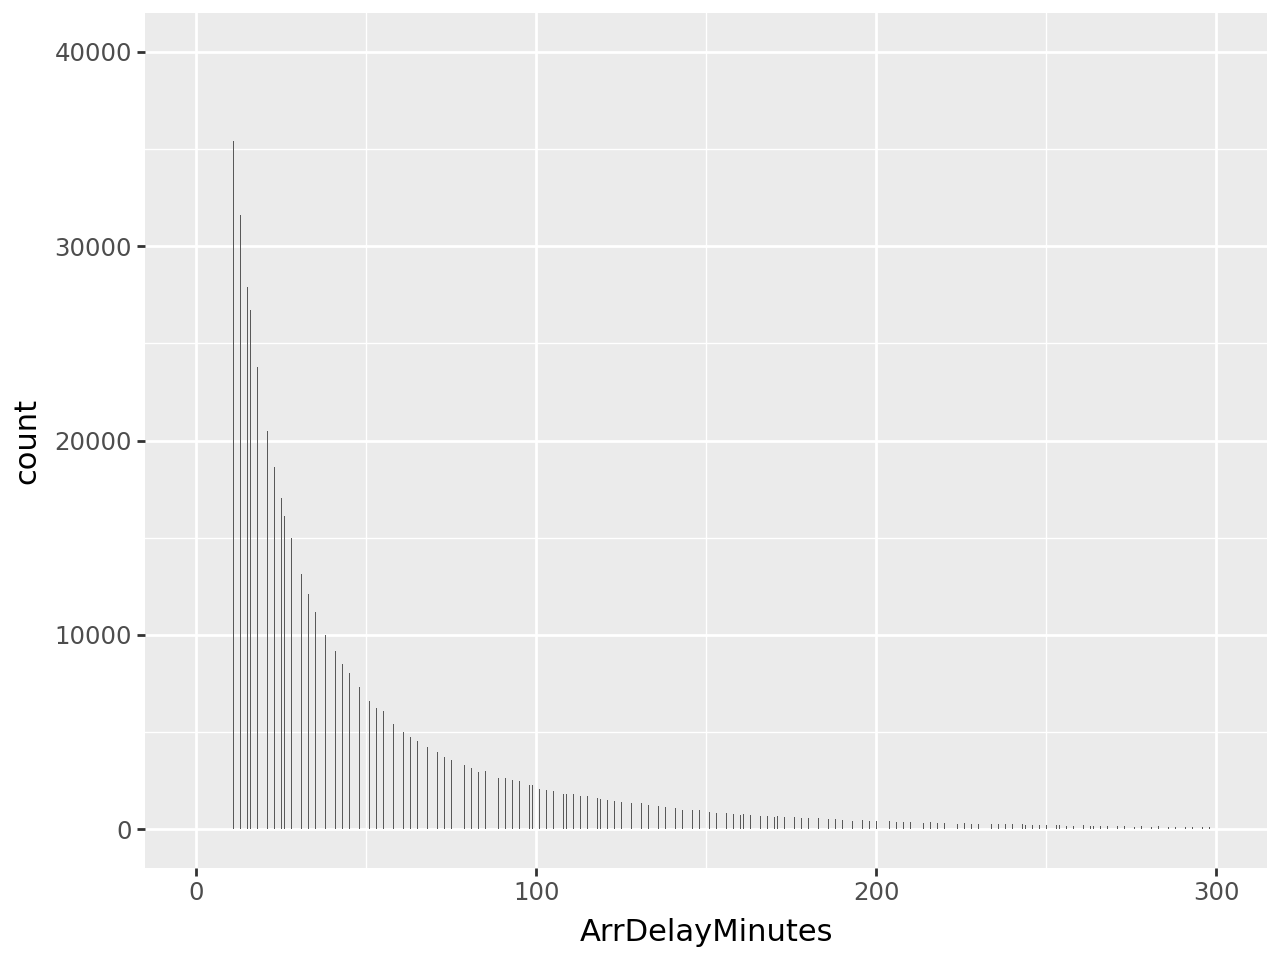

In [4]:
# Histogram of arrival delay minutes
p = (
    ggplot(Full_Data, aes(x='ArrDelayMinutes')) +
    geom_histogram() +
    xlim(0, 300) +
    ylim(0, 40000)
)
p

c:\ProgramData\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 2372'. Pick better value with 'binwidth'.
c:\ProgramData\anaconda3\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 92115 rows containing non-finite values.
c:\ProgramData\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_histogram : Removed 11 rows containing missing values.


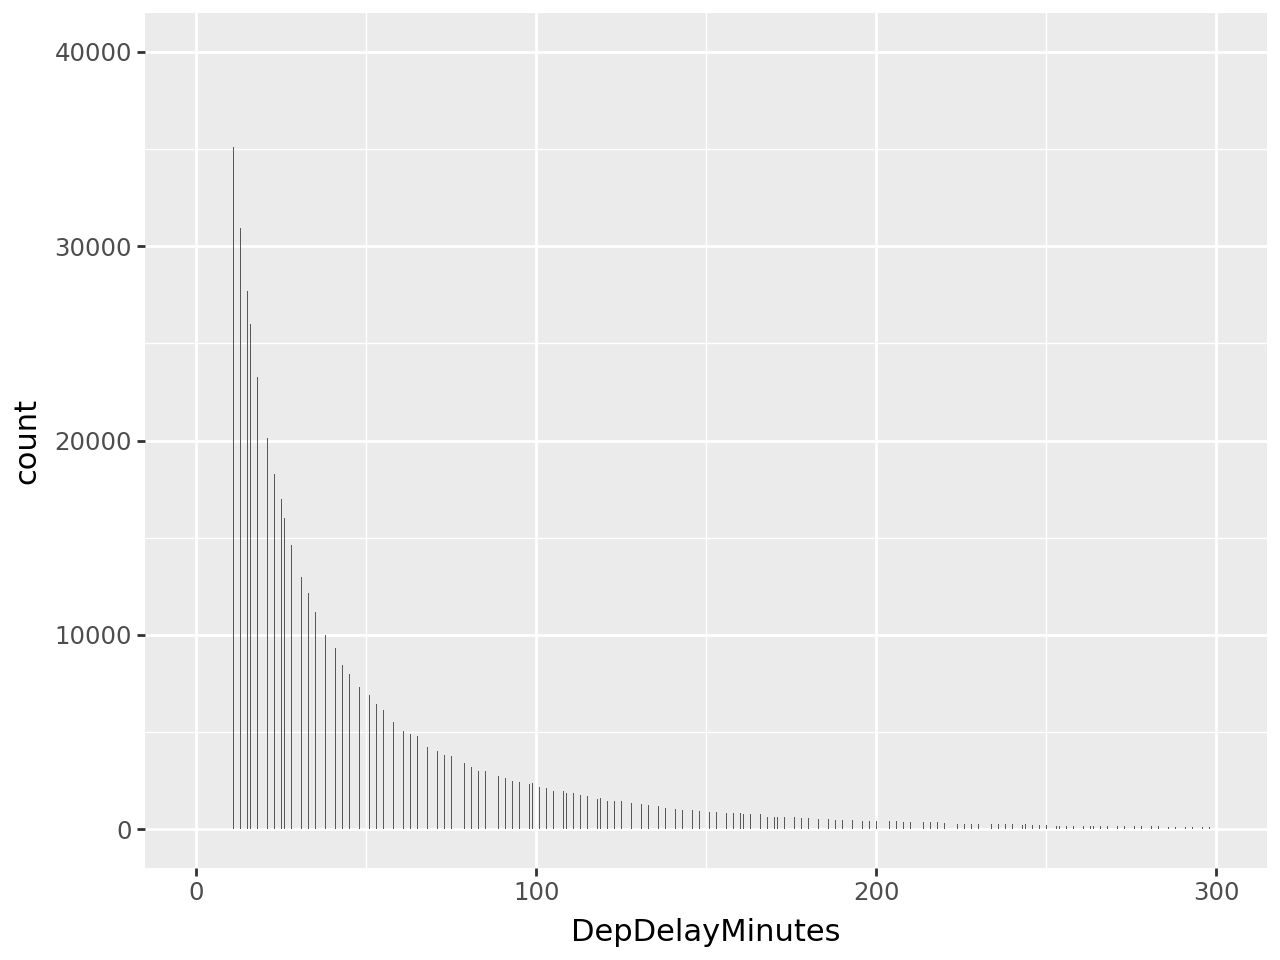

In [5]:
# Histogram of departure delay minutes
p = (
    ggplot(Full_Data, aes(x='DepDelayMinutes')) +
    geom_histogram() +
    xlim(0, 300) +
    ylim(0, 40000)
)
p

c:\ProgramData\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 1988'. Pick better value with 'binwidth'.
c:\ProgramData\anaconda3\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 3107222 rows containing non-finite values.
c:\ProgramData\anaconda3\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


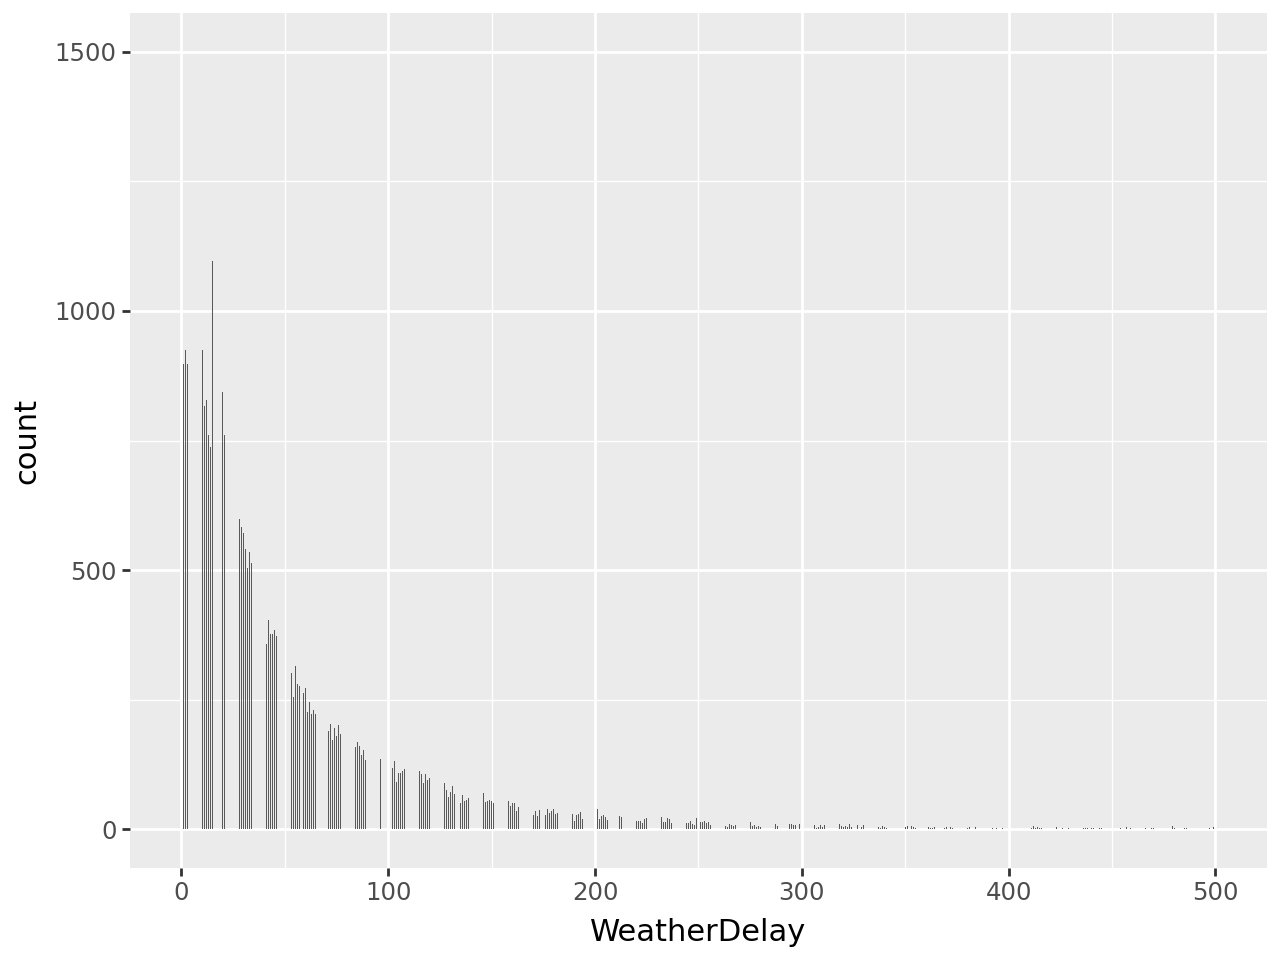

In [6]:
# Histogram of weather delay minutes
p = (
    ggplot(Full_Data, aes(x='WeatherDelay')) +
    geom_histogram() +
    xlim(0, 500) +
    ylim(0, 1500)
)
p

# 4. Normality Testing of Delay Data
Perform Shapiro-Wilk and QQ plot tests to assess normality of weather delay data.

In [7]:
# Shapiro-Wilk test for normality
stat, p = sp.stats.shapiro(weather_Delay["WeatherDelay"])
print(f"Test Statistic = {stat:.4f}")
print(f"P-Value = {p}")

Test Statistic = 0.4881
P-Value = 3.922999211029657e-143


c:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 51102.


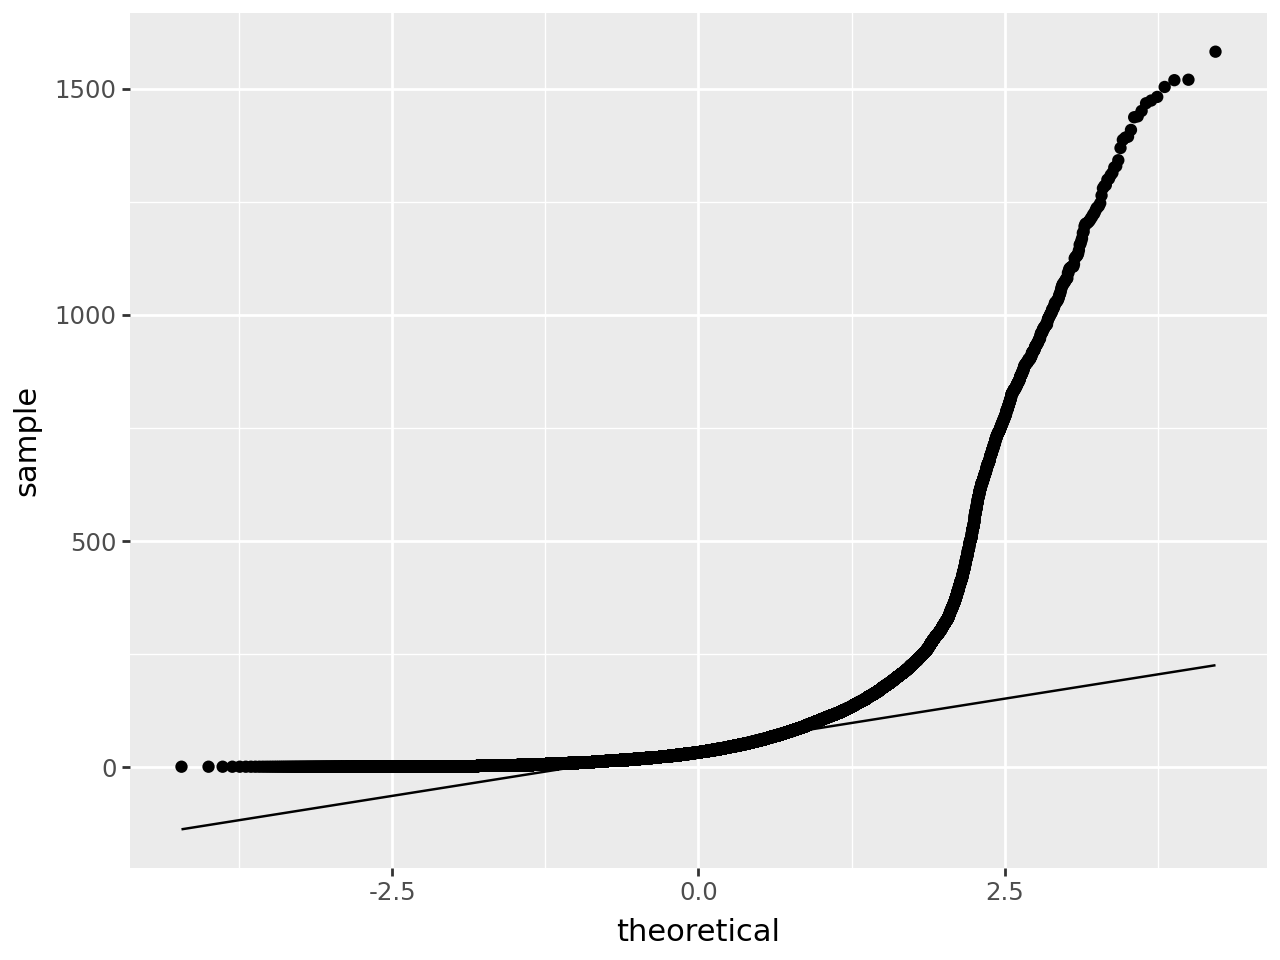

In [8]:
# QQ plot for normality
p = (ggplot(weather_Delay, aes(sample = "WeatherDelay")) +
     stat_qq() +
     stat_qq_line()
     )
p.show()

# 5. Flight Delay and Cancellation Summaries
Calculate and print total and percentage statistics for cancelled, delayed, and weather-affected flights.

In [9]:
print(f"Total Number of Flights: {len(Full_Data)}")

print(f"\nTotal Number of Cancelled Flights: {len(cancelled)}")
print(f"Percent of Cancelled Flights: {len(cancelled)/len(Full_Data):.2%}")

print(f"\nTotal Number of Cancelled Flights due to Weather: {len(cancelled_Weather)}")
print(f"Percent of Cancelled Flights due to Weather: {len(cancelled_Weather)/len(Full_Data):.2%}")
print(f"Percent of Cancelled Flights due to Weather out of total cancelled flights: {len(cancelled_Weather)/len(cancelled):.2%}")

print(f"\nTotal Number of Cancelled Flights after a Delay: {len(cancelled_Delay)}")
print(f"Percent of Cancelled Flights after a Delay: {len(cancelled_Delay)/len(Full_Data):.2%}")

print(f"\nTotal Number of Cancelled Flights due to Weather After a Delay: {len(cancelled_Weather_Delay)}")
print(f"Percent of Cancelled Flights due to Weather After a Delay: {len(cancelled_Weather_Delay)/len(Full_Data):.2%}")

print(f"\nTotal Number of Diverted Flights: {len(diverted)}")
print(f"Percent of Diverted Flights: {len(diverted)/len(Full_Data):.2%}")

print(f"\nTotal Number of Diverted Flights after a Delay: {len(diverted_Delay)}")
print(f"Percent of Diverted Flights after a Delay:: {len(diverted_Delay)/len(Full_Data):.2%}")

print(f"\nTotal Number of Delayed Flights: {len(delay)}")
print(f"Percent of Delayed Flights: {len(delay)/len(Full_Data):.2%}")

print(f"\nTotal Number of Delayed Flights due to weather: {len(weather_Delay)}")
print(f"Percent of Delayed Flights due to weather: {len(weather_Delay)/len(Full_Data):.2%}")
print(f"Percent of Delayed Flights due to weather out of total delayed flights: {len(weather_Delay)/len(delay):.2%}")

Total Number of Flights: 3949563

Total Number of Cancelled Flights: 76128
Percent of Cancelled Flights: 1.93%

Total Number of Cancelled Flights due to Weather: 42004
Percent of Cancelled Flights due to Weather: 1.06%
Percent of Cancelled Flights due to Weather out of total cancelled flights: 55.18%

Total Number of Cancelled Flights after a Delay: 1456
Percent of Cancelled Flights after a Delay: 0.04%

Total Number of Cancelled Flights due to Weather After a Delay: 748
Percent of Cancelled Flights due to Weather After a Delay: 0.02%

Total Number of Diverted Flights: 9875
Percent of Diverted Flights: 0.25%

Total Number of Diverted Flights after a Delay: 5325
Percent of Diverted Flights after a Delay:: 0.13%

Total Number of Delayed Flights: 1487799
Percent of Delayed Flights: 37.67%

Total Number of Delayed Flights due to weather: 51102
Percent of Delayed Flights due to weather: 1.29%
Percent of Delayed Flights due to weather out of total delayed flights: 3.43%


# 6. Flight Volume Correction and Delay Rate Calculation
Compute total flights per airport and calculate delay/cancellation rates normalized by flight volume.

In [10]:
# Total flights per airport (origin + destination)
num_flight_dict = {}
for code in airport_codes:
    num_flight_dict[code] = int((Full_Data["Origin"] == code).sum()) + int((Full_Data["Dest"] == code).sum())
total_flight_count = pd.Series(num_flight_dict).sort_values(ascending=False)
total_flight_count

ATL    644044
ORD    590758
DEN    566550
DFW    555178
CLT    426084
LAX    381506
LAS    364708
PHX    338390
MCO    301617
MIA    206284
dtype: int64

In [11]:
# Percentage of cancelled flights per airport (inbound)
cancelled_to = cancelled["Dest"].value_counts().head(10)
(round((cancelled_to/total_flight_count), 4)*100).sort_values(ascending=False)

MCO    1.59
DFW    1.20
MIA    1.11
DEN    1.09
ORD    1.02
LAS    1.00
CLT    0.88
PHX    0.78
ATL    0.67
LAX    0.66
dtype: float64

In [12]:
# Percentage of cancelled flights per airport (outbound)
cancelled_from = cancelled["Origin"].value_counts().head(10)
(round((cancelled_from/total_flight_count), 4)*100).sort_values(ascending=False)

MCO    1.52
DFW    1.16
MIA    1.08
DEN    1.03
ORD    0.98
LAS    0.97
CLT    0.85
PHX    0.73
ATL    0.64
LAX    0.63
dtype: float64

In [13]:
# Percentage of delayed flights per airport (outbound)
delay = Full_Data[Full_Data['ArrDel15'].notnull() & (Full_Data["ArrDel15"]) != 0]
delayed_from = delay["Origin"].value_counts().head(10)
(round((delayed_from/total_flight_count), 4)*100).sort_values(ascending=False)

MCO    14.25
LAS    13.85
DEN    12.52
DFW    12.36
MIA    12.36
PHX    10.66
CLT    10.38
ORD    10.32
ATL     9.38
LAX     9.16
dtype: float64

In [14]:
# Percentage of delayed flights per airport (inbound)
delayed_to = delay["Dest"].value_counts().head(10)
(round((delayed_to/total_flight_count), 4)*100).sort_values(ascending=False)

MCO    13.55
LAS    13.39
MIA    11.46
PHX    10.69
DFW    10.66
LAX    10.32
DEN    10.08
ORD     8.93
CLT     8.78
ATL     8.26
dtype: float64

After we look at differnet airports by different metrics, we  get to see how some do based off of some categories than another. But how do we get a definitive ranking. Let's focus on only weather delays for the rankings.

# 7. Weather Delay Analysis by Airport
Aggregate and compare weather delays, total delays, and proportions for each top airport. Calculate weather resilience metrics.

In [15]:
# Prepare data for weather delay analysis
airport_codes = ['DFW', 'DEN', 'ORD', 'MCO', 'ATL', 'CLT', 'LAS', 'PHX', 'LAX', 'MIA']
Full_Data = Full_Data.fillna(0)
Top_10_From = Full_Data[Full_Data['Origin'].isin(airport_codes)].copy()
Top_10_To = Full_Data[Full_Data['Dest'].isin(airport_codes)].copy()
delay_types = ['WeatherDelay', 'CarrierDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# Create binary columns for each delay type
for delay in delay_types:
    cat_col = delay + 'Cat'
    Top_10_From.loc[:, cat_col] = (Top_10_From[delay] != 0).astype(int)
    Top_10_To.loc[:, cat_col] = (Top_10_To[delay] != 0).astype(int)

# Total Flights
from_counts = Top_10_From['Origin'].value_counts().rename_axis('Cities').to_frame(name='FromFlights')
to_counts = Top_10_To['Dest'].value_counts().rename_axis('Cities').to_frame(name='ToFlights')
flights = from_counts.join(to_counts, how='outer').fillna(0)
flights['TotalFlights'] = flights['FromFlights'] + flights['ToFlights']

# Delay Counts for Each Type 
delay_summary = pd.DataFrame(index=airport_codes)
for delay in delay_types:
    cat_col = delay + 'Cat'
    from_delay = Top_10_From.groupby('Origin')[cat_col].sum().rename_axis('Cities')
    to_delay = Top_10_To.groupby('Dest')[cat_col].sum().rename_axis('Cities')
    delay_counts = from_delay.add(to_delay, fill_value=0).rename(delay.replace('Delay', 'Delays'))
    delay_summary = delay_summary.join(delay_counts, how='outer')

# Combine flights and delay summary
final_summary = flights[['TotalFlights']].join(delay_summary, how='outer').fillna(0)
final_summary = final_summary.sort_values(by='TotalFlights', ascending=False)

for delay in delay_types:
    delay_col = delay.replace('Delay', 'Delays')
    final_summary[delay_col + 'Rate'] = round(final_summary[delay_col] / final_summary['TotalFlights'], 4)

final_summary

,TotalFlights,WeatherDelays,CarrierDelays,NASDelays,SecurityDelays,LateAircraftDelays,WeatherDelaysRate,CarrierDelaysRate,NASDelaysRate,SecurityDelaysRate,LateAircraftDelaysRate
Cities,,,,,,,,,,,
ATL,644044,6506,71666,49221,347,47846,0.0101,0.1113,0.0764,0.0005,0.0743
ORD,590758,8836,63008,53481,279,50223,0.0150,0.1067,0.0905,0.0005,0.0850
DEN,566550,5367,84119,50700,289,62145,0.0095,0.1485,0.0895,0.0005,0.1097
DFW,555178,12885,74862,57381,656,64720,0.0232,0.1348,0.1034,0.0012,0.1166
CLT,426084,7871,43763,40807,698,43364,0.0185,0.1027,0.0958,0.0016,0.1018
LAX,381506,2658,46570,32391,412,32014,0.0070,0.1221,0.0849,0.0011,0.0839
LAS,364708,2740,59158,54361,553,55803,0.0075,0.1622,0.1491,0.0015,0.1530
PHX,338390,2196,46975,29406,384,41103,0.0065,0.1388,0.0869,0.0011,0.1215
MCO,301617,4679,51697,47432,581,42339,0.0155,0.1714,0.1573,0.0019,0.1404


Let's try an create a few more metrics to rank airports based off of.

In [16]:
# Calculate weather resilience metrics
df = final_summary.copy()
df['weather_delay_rate'] = df['WeatherDelays'] / df['TotalFlights']
df['weather_proportion'] = df['WeatherDelays'] / (
    df['WeatherDelays'] + df['NASDelays'] + df['CarrierDelays'] +
    df['SecurityDelays'] + df['LateAircraftDelays']
)
df['total_delay_rate'] = (
    df['WeatherDelays'] + df['NASDelays'] + df['CarrierDelays'] +
    df['SecurityDelays'] + df['LateAircraftDelays']
) / df['TotalFlights']

weather_threshold = df['weather_delay_rate'].quantile(0.70)
df['high_weather_delays'] = (df['weather_delay_rate'] > weather_threshold).astype(int)
expected_weather_proportion = df['weather_proportion'].mean()
df['weather_performance_ratio'] = df['weather_proportion'] / expected_weather_proportion
df['poor_weather_resilience'] = (df['weather_performance_ratio'] > 1.30).astype(int)
df['good_weather_resilience'] = (df['weather_performance_ratio'] < .70).astype(int)

df_filtered = df[[
    'TotalFlights', 'WeatherDelays', 'weather_delay_rate', 'weather_proportion',
    'total_delay_rate', 'high_weather_delays', 'weather_performance_ratio', 'poor_weather_resilience', 
    'good_weather_resilience'
]]
df_filtered = df_filtered.sort_values(by='weather_delay_rate', ascending=False)
df_filtered = df_filtered.reset_index()
df_filtered

,Cities,TotalFlights,WeatherDelays,weather_delay_rate,weather_proportion,total_delay_rate,high_weather_delays,weather_performance_ratio,poor_weather_resilience,good_weather_resilience
0,DFW,555178,12885,0.023209,0.061210,0.379165,1,1.698382,1,0
1,CLT,426084,7871,0.018473,0.057662,0.320366,1,1.599923,1,0
2,MIA,206284,3210,0.015561,0.038377,0.405480,1,1.064833,0,0
3,MCO,301617,4679,0.015513,0.031889,0.486471,0,0.884813,0,0
4,ORD,590758,8836,0.014957,0.050254,0.297629,0,1.394381,1,0
5,ATL,644044,6506,0.010102,0.037053,0.272630,0,1.028100,0,0
6,DEN,566550,5367,0.009473,0.026488,0.357638,0,0.734955,0,0
7,LAS,364708,2740,0.007513,0.015873,0.473296,0,0.440437,0,1
8,LAX,381506,2658,0.006967,0.023307,0.298934,0,0.646681,0,1
9,PHX,338390,2196,0.006490,0.018290,0.354810,0,0.507494,0,1


# 8. Load and Prepare External Storm Data
But since airports shouldn't be ranked differently due to experiencein more storm events we should use weather as a corrective. 
Read storm event CSVs, filter for relevant dates and event types, and map storm events to airport regions.

In [17]:
# Load storm event data (NOAA)
storm_details_2022 = pd.read_csv("C:/Users/alexc/MSA/1. Summer/IAA_2026_Team_12_Summer_Practicum/data/External Data/StormEvents_details-ftp_v1.0_d2022_c20250520.csv")
storm_details_2022 = storm_details_2022[storm_details_2022['BEGIN_YEARMONTH'] >= 202204]
storm_details_2023 = pd.read_csv("C:/Users/alexc/MSA/1. Summer/IAA_2026_Team_12_Summer_Practicum/data/External Data/StormEvents_details-ftp_v1.0_d2023_c20250520.csv")
storm_details_2023 = storm_details_2023[storm_details_2023['BEGIN_YEARMONTH'] <= 202303]  
storm_details = pd.concat([storm_details_2022, storm_details_2023])

likely_delay_events = [
    'Blizzard', 'Coastal Flood', 'Cold/Wind Chill', 'Dense Fog',
    'Dense Smoke', 'Dust Storm', 'Extreme Cold/Wind Chill', 'Flash Flood',
    'Flood', 'Freezing Fog', 'Frost/Freeze', 'Hail',
    'Heavy Rain', 'Heavy Snow', 'High Wind', 'Hurricane (Typhoon)',
    'Ice Storm', 'Lake-Effect Snow', 'Lakeshore Flood', 'Lightning',
    'Sleet', 'Smoke', 'Storm Surge/Tide', 'Strong Wind',
    'Thunderstorm Wind', 'Tornado', 'Tropical Depression', 'Tropical Storm',
    'Volcanic Ash', 'Wildfire', 'Winter Storm','Winter Weather'
]
storm_details = storm_details[storm_details['EVENT_TYPE'].isin(likely_delay_events)]

areas = ['DALLAS', 'LOS ANGELES', 'CHARLOTTE',
         'MIAMI', 'DENVER', 'COOK', 'MIAMI-DADE', 'MECKLENBURG', 'ORANGE', 'CLARK',
          'FULTON', 'DEKALB', 'MARICOPA']
storm_details = storm_details[storm_details['CZ_NAME'].str.upper().isin(areas)]

# 9. Aggregate Storm Events by Airport
Count the number of significant storms per airport region and create a mapping to airport codes.

In [18]:
# Count storm events by region and map to airport codes
num_storms = storm_details['CZ_NAME'].value_counts().reindex(areas)
num_storms.index.name = 'Cities'
num_storms_df = num_storms.reset_index().rename(columns={'CZ_NAME': 'count'})

# Manual corrections for missing/merged counties (if needed)
num_storms_df.at[7, 'count'] = 51
num_storms_df = num_storms_df[num_storms_df["Cities"] != 'CHARLOTTE']
num_storms_df.at[6, 'count'] = 66
num_storms_df = num_storms_df[num_storms_df["Cities"] != 'MIAMI']
num_storms_df.at[10, 'count'] = 155
num_storms_df = num_storms_df[num_storms_df["Cities"] != 'DEKALB']
num_storms_df.at[4, 'count'] = 21

num_storms_df = num_storms_df.reset_index()
num_storms_df = num_storms_df.drop('index', axis=1)

city_to_airport = {
    'DALLAS': 'DFW',
    'FULTON': 'ATL',
    'COOK': 'ORD',
    'LOS ANGELES': 'LAX',
    'MECKLENBURG': 'CLT',
    'ORANGE': 'MCO',
    'CLARK': 'LAS',
    'MARICOPA': 'PHX',
    'MIAMI-DADE': 'MIA',
    'DENVER': 'DEN'
}

num_storms = num_storms_df.set_index('Cities').reindex(city_to_airport.keys()).fillna(0).astype(int)
num_storms = num_storms.reset_index()
num_storms.columns = ['City', 'Storm_Count']
num_storms['Airport_Code'] = num_storms['City'].map(city_to_airport)
num_storms = num_storms[['Airport_Code', 'Storm_Count']]
num_storms

,Airport_Code,Storm_Count
0,DFW,99
1,ATL,155
2,ORD,191
3,LAX,20
4,CLT,51
5,MCO,119
6,LAS,160
7,PHX,261
8,MIA,66
9,DEN,21


# 10. Merge Flight and Storm Data
Merge airport delay metrics with storm counts to create a combined dataset for analysis.

In [19]:
# Merge delay metrics with storm counts
df_combined = pd.merge(df_filtered, num_storms, left_on='Cities', right_on='Airport_Code')

# Calculate delays per storm
df_combined['delays_per_storm'] = df_combined.apply(
    lambda row: row['WeatherDelays'] / row['Storm_Count'],
    axis=1
)
df_combined

,Cities,TotalFlights,WeatherDelays,weather_delay_rate,weather_proportion,total_delay_rate,high_weather_delays,weather_performance_ratio,poor_weather_resilience,good_weather_resilience,Airport_Code,Storm_Count,delays_per_storm
0,DFW,555178,12885,0.023209,0.061210,0.379165,1,1.698382,1,0,DFW,99,130.151515
1,CLT,426084,7871,0.018473,0.057662,0.320366,1,1.599923,1,0,CLT,51,154.333333
2,MIA,206284,3210,0.015561,0.038377,0.405480,1,1.064833,0,0,MIA,66,48.636364
3,MCO,301617,4679,0.015513,0.031889,0.486471,0,0.884813,0,0,MCO,119,39.319328
4,ORD,590758,8836,0.014957,0.050254,0.297629,0,1.394381,1,0,ORD,191,46.261780
5,ATL,644044,6506,0.010102,0.037053,0.272630,0,1.028100,0,0,ATL,155,41.974194
6,DEN,566550,5367,0.009473,0.026488,0.357638,0,0.734955,0,0,DEN,21,255.571429
7,LAS,364708,2740,0.007513,0.015873,0.473296,0,0.440437,0,1,LAS,160,17.125000
8,LAX,381506,2658,0.006967,0.023307,0.298934,0,0.646681,0,1,LAX,20,132.900000
9,PHX,338390,2196,0.006490,0.018290,0.354810,0,0.507494,0,1,PHX,261,8.413793


# 11. Calculate Delays per Storm and Performance Classification
Compute delays per storm, classify airports by performance (resilient, vulnerable, typical), and rank airports overall and within categories.

In [20]:
# Set index for easier plotting
df_combined = df_combined.reset_index(drop=True)
df_combined = df_combined.drop('Airport_Code', axis=1)
df_combined = df_combined.set_index('Cities')

# Classification logic
high_delay = df_combined['weather_delay_rate'].quantile(0.51)
low_delay = df_combined['weather_delay_rate'].quantile(0.49)
high_storms = df_combined['Storm_Count'].quantile(0.51)
low_storms = df_combined['Storm_Count'].quantile(0.49)

def classify(row):
    if row['Storm_Count'] <= low_storms and row['weather_delay_rate'] >= high_delay:
        return 'High Delays, Low Storms'  # Vulnerable
    elif row['Storm_Count'] >= high_storms and row['weather_delay_rate'] <= low_delay:
        return 'Low Delays, High Storms'  # Resilient
    else:
        return 'Typical'

df_combined['PerformanceType'] = df_combined.apply(classify, axis=1)

# Delays per storm and ranking
df_combined['DelayPerStorm'] = df_combined['WeatherDelays'] / df_combined['Storm_Count']
df_combined['Rank_Overall'] = df_combined['DelayPerStorm'].rank(ascending=False)
df_combined['Rank_Per_Type'] = df_combined.groupby('PerformanceType')['DelayPerStorm'].rank(ascending=False)
df_combined

,TotalFlights,WeatherDelays,weather_delay_rate,weather_proportion,total_delay_rate,high_weather_delays,weather_performance_ratio,poor_weather_resilience,good_weather_resilience,Storm_Count,delays_per_storm,PerformanceType,DelayPerStorm,Rank_Overall,Rank_Per_Type
Cities,,,,,,,,,,,,,,,
DFW,555178,12885,0.023209,0.061210,0.379165,1,1.698382,1,0,99,130.151515,"High Delays, Low Storms",130.151515,4.0,2.0
CLT,426084,7871,0.018473,0.057662,0.320366,1,1.599923,1,0,51,154.333333,"High Delays, Low Storms",154.333333,2.0,1.0
MIA,206284,3210,0.015561,0.038377,0.405480,1,1.064833,0,0,66,48.636364,"High Delays, Low Storms",48.636364,5.0,3.0
MCO,301617,4679,0.015513,0.031889,0.486471,0,0.884813,0,0,119,39.319328,Typical,39.319328,8.0,4.0
ORD,590758,8836,0.014957,0.050254,0.297629,0,1.394381,1,0,191,46.261780,Typical,46.261780,6.0,3.0
ATL,644044,6506,0.010102,0.037053,0.272630,0,1.028100,0,0,155,41.974194,"Low Delays, High Storms",41.974194,7.0,1.0
DEN,566550,5367,0.009473,0.026488,0.357638,0,0.734955,0,0,21,255.571429,Typical,255.571429,1.0,1.0
LAS,364708,2740,0.007513,0.015873,0.473296,0,0.440437,0,1,160,17.125000,"Low Delays, High Storms",17.125000,9.0,2.0
LAX,381506,2658,0.006967,0.023307,0.298934,0,0.646681,0,1,20,132.900000,Typical,132.900000,3.0,2.0


# 12. Visualize Delay Rates and Storm Exposure
Create bar charts and scatter plots to visualize weather delay rates, storm counts, delays per storm, and performance classifications.

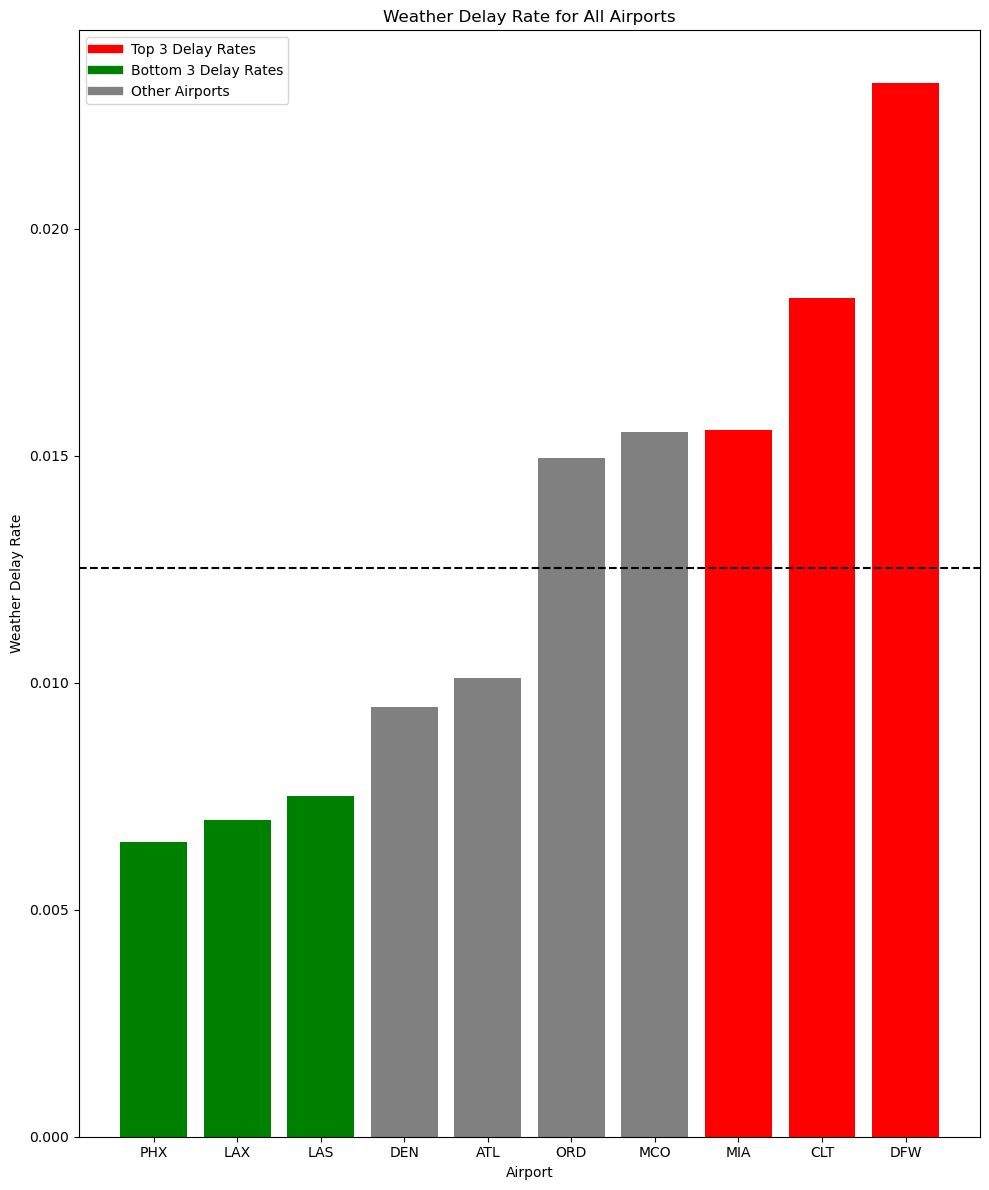

In [ ]:
# Weather Delay Rate for All Airports
import numpy as np

top3_idx = df_combined.nlargest(3, 'weather_delay_rate').index
bottom3_idx = df_combined.nsmallest(3, 'weather_delay_rate').index
colors = np.where(df_combined.index.isin(top3_idx), 'red',
         np.where(df_combined.index.isin(bottom3_idx), 'green', 'gray'))
df_sorted = df_combined.sort_values('weather_delay_rate', ascending=True)
colors_sorted = [colors[df_combined.index.get_loc(i)] for i in df_sorted.index]

plt.figure(figsize=(10, 12))
plt.bar(df_sorted.index, df_sorted['weather_delay_rate'], color=colors_sorted)
plt.xlabel('Airport')
plt.ylabel('Weather Delay Rate')
plt.title('Weather Delay Rate for All Airports')
plt.axhline(df_combined['weather_delay_rate'].median(), color='black', linestyle='--', label='Average Weather Delay Rate')
plt.legend(handles=[
    plt.Line2D([0], [0], color='red', lw=6, label='Top 3 Delay Rates'),
    plt.Line2D([0], [0], color='green', lw=6, label='Bottom 3 Delay Rates'),
    plt.Line2D([0], [0], color='gray', lw=6, label='Other Airports')
])
plt.tight_layout()
plt.show()

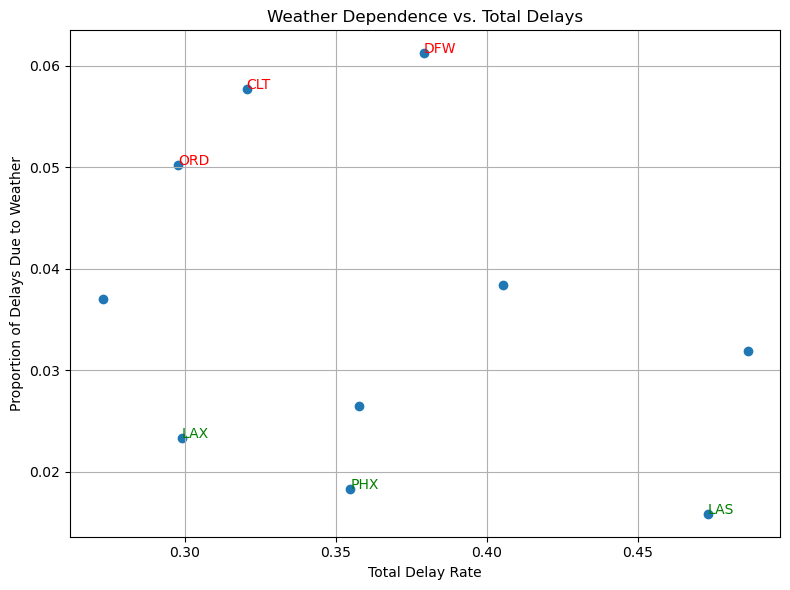

In [ ]:
# Weather Proportion vs Total Delay Rate
plt.figure(figsize=(8, 6))
plt.scatter(df_combined['total_delay_rate'], df_combined['weather_proportion'])

# Annotate top 3 by weather_proportion in red, using city names
for i in df_combined.nlargest(3, 'weather_proportion').index:
    plt.annotate(i, 
                 (df_combined.loc[i, 'total_delay_rate'], df_combined.loc[i, 'weather_proportion']),
                 color='red')

# Annotate bottom 3 by weather_proportion in green, using city names
for i in df_combined.nsmallest(3, 'weather_proportion').index:
    plt.annotate(i, 
                 (df_combined.loc[i, 'total_delay_rate'], df_combined.loc[i, 'weather_proportion']),
                 color='green')

plt.xlabel('Total Delay Rate')
plt.ylabel('Proportion of Delays Due to Weather')
plt.title('Weather Dependence vs. Total Delays')
plt.grid(True)
plt.tight_layout()
plt.show()

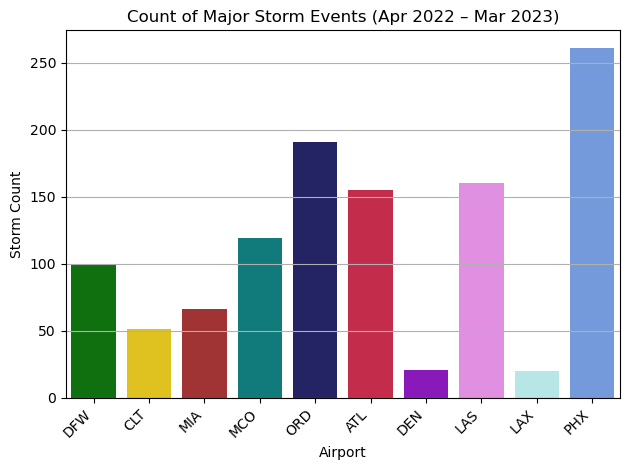

In [ ]:
# Storm Count per Airport
sns.barplot(x=df_combined.index, y='Storm_Count', data=df_combined.reset_index(), hue='Cities', dodge=False,
            palette={
                'ATL': 'crimson',
                'DFW': 'green',
                'LAX': 'paleturquoise',
                'CLT': 'gold',
                'PHX': 'cornflowerblue',
                'LAS': 'violet',
                'DEN': 'darkviolet',
                'MIA': 'firebrick',
                'MCO': 'darkcyan',
                'ORD': 'midnightblue'
            })
plt.title("Count of Major Storm Events (Apr 2022 – Mar 2023)")
plt.xlabel('Airport')
plt.ylabel('Storm Count')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

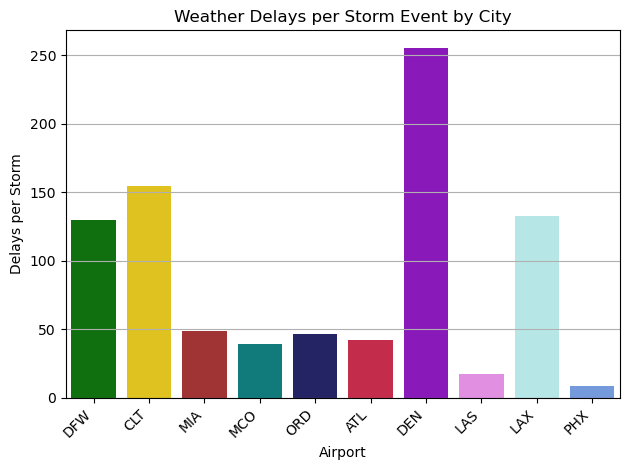

In [ ]:
# Delays per Storm Event by City
sns.barplot(x=df_combined.index, y='delays_per_storm', data=df_combined.reset_index(), hue='Cities', dodge=False,
            palette={
                'ATL': 'crimson',
                'DFW': 'green',
                'LAX': 'paleturquoise',
                'CLT': 'gold',
                'PHX': 'cornflowerblue',
                'LAS': 'violet',
                'DEN': 'darkviolet',
                'MIA': 'firebrick',
                'MCO': 'darkcyan',
                'ORD': 'midnightblue'
            })
plt.title('Weather Delays per Storm Event by City')
plt.xlabel('Airport')
plt.ylabel('Delays per Storm')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

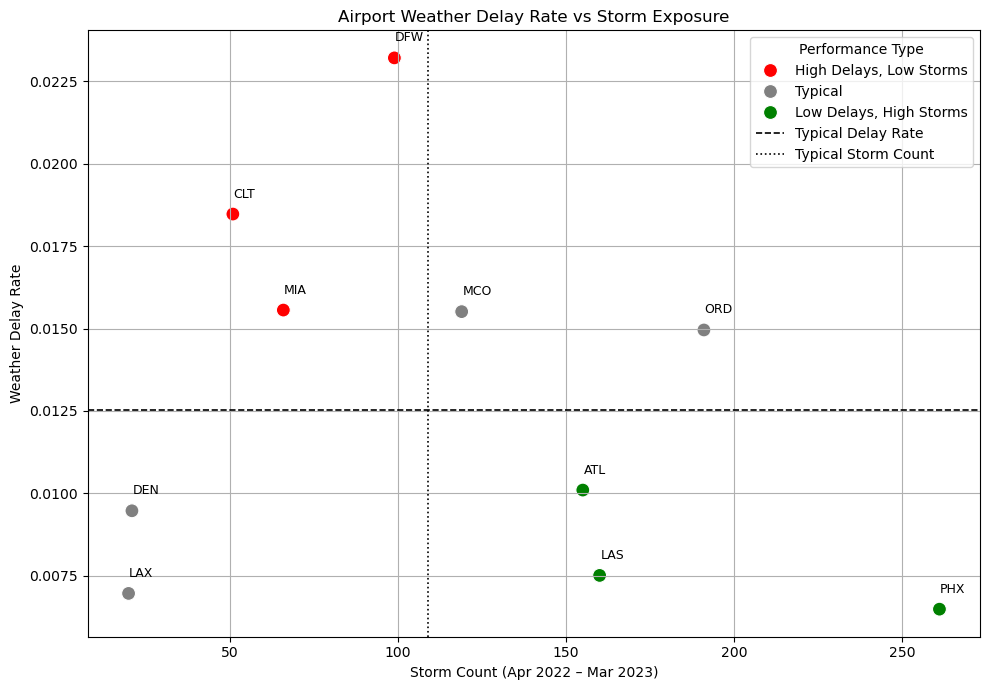

In [ ]:
# Weather Delay Rate vs Storm Exposure (Performance Classification)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_combined,
    x='Storm_Count',
    y='weather_delay_rate',
    hue='PerformanceType',
    palette={
        'High Delays, Low Storms': 'red',
        'Low Delays, High Storms': 'green',
        'Typical': 'gray'
    },
    s=100
)
for i, row in df_combined.iterrows():
    plt.text(row['Storm_Count'] + 0.2, row['weather_delay_rate'] + 0.0005, i, fontsize=9)
median_storms = df_combined['Storm_Count'].median()
median_delay_rate = df_combined['weather_delay_rate'].median()
plt.axhline(median_delay_rate, color='black', linestyle='--', linewidth=1.2, label='Typical Delay Rate')
plt.axvline(median_storms, color='black', linestyle=':', linewidth=1.2, label='Typical Storm Count')
plt.title("Airport Weather Delay Rate vs Storm Exposure")
plt.xlabel("Storm Count (Apr 2022 – Mar 2023)")
plt.ylabel("Weather Delay Rate")
plt.legend(title='Performance Type')
plt.grid(True)
plt.tight_layout()
plt.show()

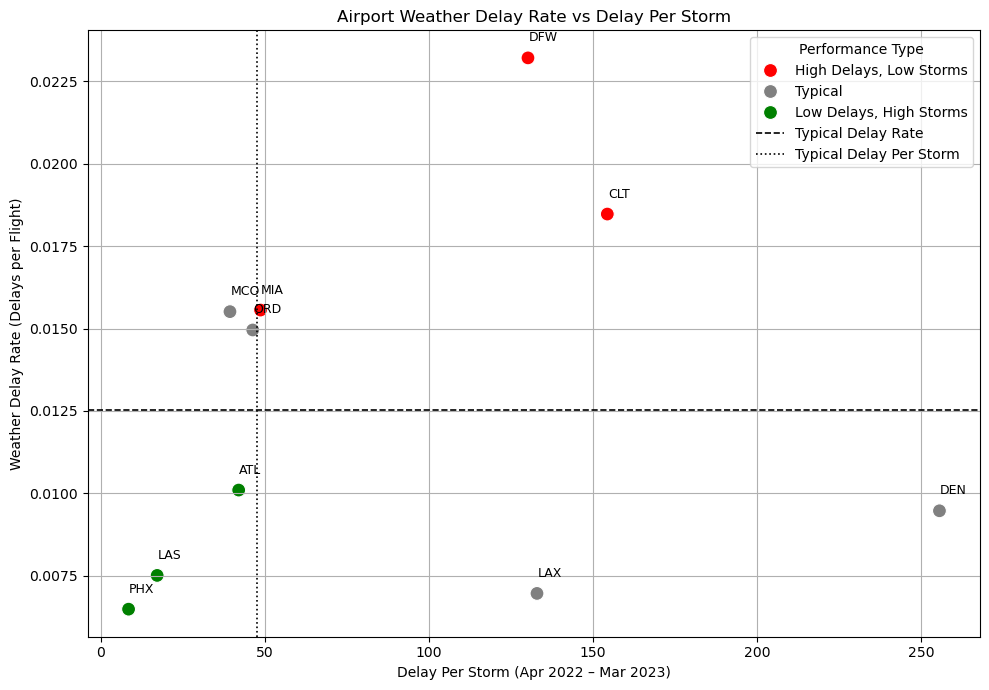

In [ ]:
# Weather Delay Rate vs Delays per Storm (Performance Classification)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_combined,
    x='delays_per_storm',
    y='weather_delay_rate',
    hue='PerformanceType',
    palette={
        'High Delays, Low Storms': 'red',
        'Low Delays, High Storms': 'green',
        'Typical': 'gray'
    },
    s=100
)
for i, row in df_combined.iterrows():
    plt.text(row['delays_per_storm'] + 0.2, row['weather_delay_rate'] + 0.0005, i, fontsize=9)
median_storms = df_combined['delays_per_storm'].median()
median_delay_rate = df_combined['weather_delay_rate'].median()
plt.axhline(median_delay_rate, color='black', linestyle='--', linewidth=1.2, label='Typical Delay Rate')
plt.axvline(median_storms, color='black', linestyle=':', linewidth=1.2, label='Typical Delay Per Storm')
plt.title("Airport Weather Delay Rate vs Delay Per Storm")
plt.xlabel("Delay Per Storm (Apr 2022 – Mar 2023)")
plt.ylabel("Weather Delay Rate (Delays per Flight)")
plt.legend(title='Performance Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# 13. Rank Airports by Delay per Storm and Performance Type
Display tables and charts ranking airports by delays per storm, both overall and within performance categories.

In [ ]:
# Top airports by delays per storm (overall)
summary_table = df_combined.reset_index()[['Cities', 'WeatherDelays', 'Storm_Count', 'delays_per_storm']] \
                .sort_values('delays_per_storm', ascending=False) \
                .reset_index(drop=True)
from tabulate import tabulate
print(tabulate(summary_table.head(10), headers='keys', tablefmt='github', showindex=False))

| Cities   |   WeatherDelays |   Storm_Count |   delays_per_storm |
|----------|-----------------|---------------|--------------------|
| DEN      |            5367 |            21 |          255.571   |
| CLT      |            7871 |            51 |          154.333   |
| LAX      |            2658 |            20 |          132.9     |
| DFW      |           12885 |            99 |          130.152   |
| MIA      |            3210 |            66 |           48.6364  |
| ORD      |            8836 |           191 |           46.2618  |
| ATL      |            6506 |           155 |           41.9742  |
| MCO      |            4679 |           119 |           39.3193  |
| LAS      |            2740 |           160 |           17.125   |
| PHX      |            2196 |           261 |            8.41379 |


In [ ]:
# Top airports by delays per storm within each performance type
for category in df_combined['PerformanceType'].unique():
    print(f"\nTop Airports in '{category}':")
    print(df_combined[df_combined['PerformanceType'] == category] \
        .sort_values('DelayPerStorm', ascending=False) \
        .head(5)[['Storm_Count', 'weather_delay_rate', 'DelayPerStorm', 'Rank_Per_Type']])


Top Airports in 'High Delays, Low Storms':
        Storm_Count  weather_delay_rate  DelayPerStorm  Rank_Per_Type
Cities                                                               
CLT              51            0.018473     154.333333            1.0
DFW              99            0.023209     130.151515            2.0
MIA              66            0.015561      48.636364            3.0

Top Airports in 'Typical':
        Storm_Count  weather_delay_rate  DelayPerStorm  Rank_Per_Type
Cities                                                               
DEN              21            0.009473     255.571429            1.0
LAX              20            0.006967     132.900000            2.0
ORD             191            0.014957      46.261780            3.0
MCO             119            0.015513      39.319328            4.0

Top Airports in 'Low Delays, High Storms':
        Storm_Count  weather_delay_rate  DelayPerStorm  Rank_Per_Type
Cities                                      

- Raw DelayPerStorm can be misleading when rare, high impact events (like a single hurricane) inflate the delay average for an airport.  
- By ranking within each storm category, you're comparing airports under equivalent weather pressure.  
- This makes the ranking more representative of operational performance over time, not just one-off events.

# 14. Show Change Before and After Correction
Create Ranking Chart


In [29]:
def create_rank_change_chart(items, before_ranks, after_ranks, title = "Rank Changes"):
    fig, ax = plt.subplots(figsize=(10, 8), facecolor = 'white')
    
    palette = {
        'ATL': 'crimson',
        'DFW': 'green',
        'LAX': 'paleturquoise',
        'CLT': 'gold',
        'PHX': 'cornflowerblue',
        'LAS': 'violet',
        'DEN': 'darkviolet',
        'MIA': 'firebrick',
        'MCO': 'darkcyan',
        'ORD': 'midnightblue'
    }

    x_before = 0
    x_after = 1
    y_positions = np.linspace(0.9,0.1,10)

    for i, item in enumerate(items):
        before_rank = before_ranks[i]
        after_rank = after_ranks[i]

        y_before = y_positions[before_rank-1]
        y_after = y_positions[after_rank-1]

        if before_rank < after_rank:
            color = 'red'
            linewidth = 2.5
            alpha = 0.8
        elif before_rank > after_rank:
            color = 'green'
            linewidth = 2.5
            alpha = 0.8
        else: 
            color = 'gray'
            linewidth = 2
            alpha = 0.6

        ax.plot([x_before, x_after], [y_before, y_after], color = color, alpha = alpha, linewidth = linewidth, zorder=1)
            
        circle_size = 300
        ax.scatter(x_before, y_before, color=palette.get(item, '#34495E'), s=circle_size, zorder=3, edgecolor='white', linewidth=2)
        ax.scatter(x_after, y_after, color=palette.get(item, '#34495E'), s=circle_size, zorder=3, edgecolor='white', linewidth=2)

        fontsize = 13
        fontweight = 'bold'

        ax.text(x_before - 0.05, y_before, f"{item} ({before_rank})", ha='right', va='center', fontsize=fontsize, fontweight=fontweight)
        ax.text(x_after + 0.05, y_after, f"({after_rank}) {item}", ha='left', va='center', fontsize=fontsize, fontweight=fontweight)

    ax.text(x_before, 0.98, 'BEFORE', ha='center', va='top', fontsize = 14, fontweight='bold', alpha=0.8)
    ax.text(x_after, 0.98, 'AFTER', ha='center', va='top', fontsize = 14, fontweight='bold', alpha=0.8)

    ax.axvline(x=x_before, color='gray', alpha=0.2, linestyle='--', linewidth=1)
    ax.axvline(x=x_after, color='gray', alpha=0.2, linestyle='--', linewidth=1)

    ax.text(0.5, 1.06, title, ha='center', va='top', fontsize=18, fontweight='bold', transform = ax.transAxes)

    ax.set_xticks([])
    ax.set_xlim(-0.05, 1.05)
    ax.set_yticks([])
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    #ax.set_facecolor('#FAFAFA')

    plt.tight_layout()
    return fig

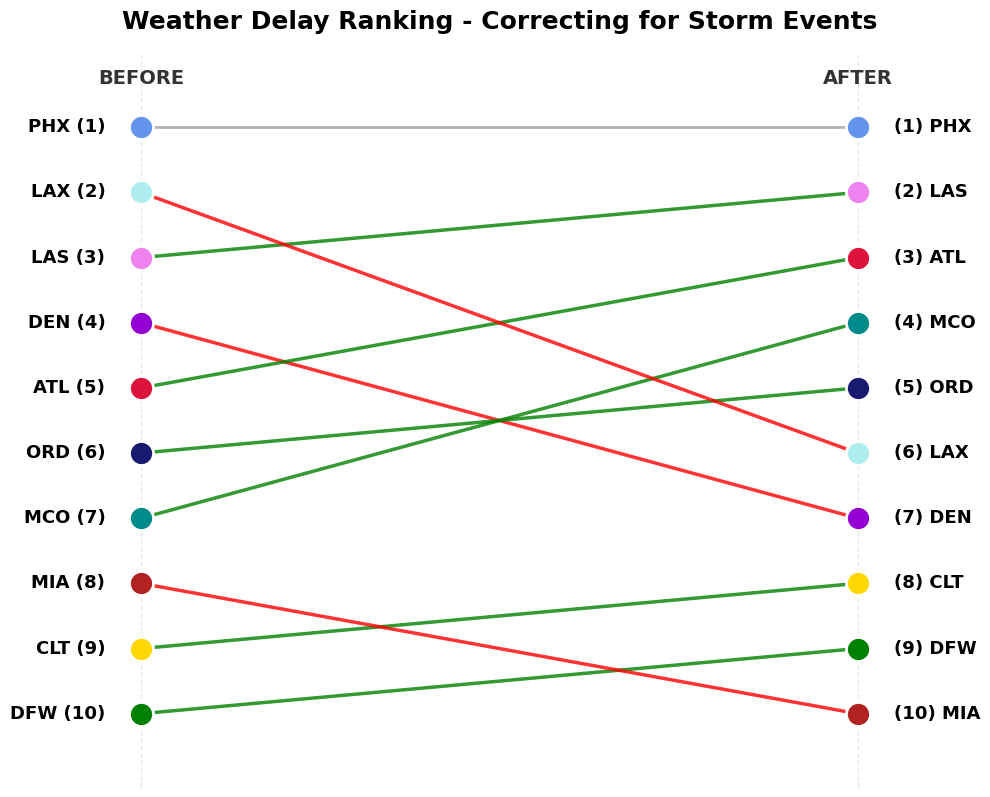

In [39]:
before_ranks = [10, 4, 6, 7, 5, 9, 3, 1, 2, 8]
after_ranks = [9, 7, 5, 4, 3, 8, 2, 1, 6, 10]
fig = create_rank_change_chart(airport_codes, before_ranks, after_ranks, "Weather Delay Ranking - Correcting for Storm Events")
fig